In [3]:
import os
import cv2
import numpy as np
import math
import matplotlib.pyplot as plt
import argparse

os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"  # Arrange GPU devices starting from 0
os.environ["CUDA_VISIBLE_DEVICES"]= "4"  # Set the GPUs 2 and 3 to use
class Options:
    def __init__(self):
        self.parser = argparse.ArgumentParser()

        self.initialized = True

    def parse(self, parse_args=None):
        if not self.initialized:
            self.initialaize()

        if parse_args is None:
            self.opt, unknown = self.parser.parse_known_args()
            # self.opt = self.parser.parse_args()
        else:
            self.opt, unknown = self.parser.parse_known_args(parse_args)
            # self.opt = self.parser.parse_args(parse_args)
            
        # self.opt.num_spheres_min = 1
        # self.opt.num_spheres_max = 5

        # self.opt.minx = -0.15
        # self.opt.maxx = 0.15
        # self.opt.miny = -0.2
        # self.opt.maxy = 0.
        # self.opt.minz = 0.5
        # self.opt.maxz = 1.
        
        # self.opt.minr = 0.05/2
        # self.opt.maxr = 0.3/2

        # self.opt.roughness_min = 0.01
        # self.opt.roughness_max = 0.6

        self.opt.camera_pitch = 3.45e-6*2
        # self.opt.lens_focal_length = 1.1418e-2
        self.opt.lens_focal_length_x = (1.1418e3) * self.opt.camera_pitch # # of pixels * camera pitch
        self.opt.lens_focal_length_y = (1146.27185717937) * self.opt.camera_pitch
        
        # self.opt.camera_row = 1024
        # self.opt.camera_col = 1224

        # self.opt.resizing_factor = 10
        
        self.opt.camera_row = 512
        self.opt.camera_col = 612

        self.opt.resizing_factor = 1
        
        self.opt.R = int(self.opt.camera_row / self.opt.resizing_factor)
        self.opt.C = int(self.opt.camera_col / self.opt.resizing_factor)

        self.opt.valid_R = self.opt.R - self.opt.R%8
        self.opt.valid_C = self.opt.C - self.opt.C%8

        self.opt.background_distance = 2

        self.opt.path = './sphere_debug'

        self.opt.num_dataset = 1

        return self.opt
    
class pos2d:
    def __init__(self, *args):
        if len(args) == 1:
            self.x = args[0][0]
            self.y = args[0][1]
        elif len(args) == 2:
            self.x = args[0]
            self.y = args[1]
    def __repr__(self):
        return 'pos2d[{}, {}, {}]'.format(self.x, self.y)
    def __str__(self):
        return 'pos2d[{}, {}]'.format(self.x, self.y)
    def np(self):
        return np.array([self.x, self.y])
    def np_homo(self):
        return np.array([self.x, self.y, 1])
    
class pos3d:
    def __init__(self, *args):
        if len(args) == 1:
            self.x = args[0][0]
            self.y = args[0][1]
            self.z = args[0][2]
        elif len(args) == 3:
            self.x = args[0]
            self.y = args[1]
            self.z = args[2]
    def __repr__(self):
        return 'pos3d[{}, {}, {}]'.format(self.x, self.y, self.z)
    def __str__(self):
        return 'pos3d[{}, {}, {}]'.format(self.x, self.y, self.z)
    def np(self):
        return np.array([self.x, self.y, self.z])
    def np_homo(self):
        return np.array([self.x, self.y, self.z, 1])

def calc_camera_pos(ex_m):    
    center = pos3d(np.linalg.inv(ex_m) @ np.array([0, 0, 0, 1]))
    look = pos3d(np.linalg.inv(ex_m) @ np.array([0, 0, 1, 1]))
    
    return center, look

def calc_reflection(v_in: pos3d, v_norm: pos3d):
    v_proj = v_norm.np() * np.dot(-v_in.np(), v_norm.np())
    v_out = v_in.np() + 2 * v_proj
    
    return pos3d(v_out)

def calc_sphere_center(in_m, ex_m, image_size: pos2d, pos_image: pos2d, radius_image, radius):
    [[f_x, _, c_x], [_, _, c_y], [_, _, _]] = in_m
    fov_x = math.atan(image_size.x / 2 / f_x)    
    pos_image = pos2d(pos_image.x - c_x, pos_image.y - c_y)
    
    theta = math.atan(radius_image / ((image_size.x / 2 / math.tan(fov_x)) + (2 * pos_image.x * pos_image.x * math.tan(fov_x) / image_size.x) + (2 * pos_image.x * radius_image * math.tan(fov_x) / image_size.x)))
    distance = radius / math.sin(theta)
    
    v = np.array([pos_image.x, pos_image.y, (image_size.x / 2) / math.tan(fov_x)])
    v = pos3d(v / np.linalg.norm(v) * distance)
    
    pos_sphere_center = np.linalg.inv(ex_m) @ v.np_homo()
    
    return pos3d(pos_sphere_center)

def calc_image2world(in_m, ex_m, image_size: pos2d, pos_image: pos2d, distance):
    [[f_x, _, c_x], [_, _, c_y], [_, _, _]] = in_m
    fov_x = math.atan(image_size.x / 2 / f_x)    
    pos_image = pos2d(pos_image.x - c_x, pos_image.y - c_y)
        
    v = np.array([pos_image.x, pos_image.y, (image_size.x / 2) / math.tan(fov_x)])
    v = pos3d(v / np.linalg.norm(v) * distance)
    
    pos_world = np.linalg.inv(ex_m) @ v.np_homo()
    
    return pos3d(pos_world)

def calc_image2world_vec(in_m, ex_m, image_size: pos2d, pos_image: pos2d):
    pos_point = calc_image2world(in_m, ex_m, image_size, pos_image, 1)
    pos_cam, _ = calc_camera_pos(ex_m)
    
    return pos3d(pos_point.x - pos_cam.x, pos_point.y - pos_cam.y, pos_point.z - pos_cam.z)

def calc_point_on_sphere(pos_ray_init: pos3d, vec_ray: pos3d, sphere_center: pos3d, sphere_radius):
    elem1 = vec_ray.x * vec_ray.x + vec_ray.y * vec_ray.y + vec_ray.z * vec_ray.z
    elem2 = 2 * (
        vec_ray.x * (pos_ray_init.x - sphere_center.x) +
        vec_ray.y * (pos_ray_init.y - sphere_center.y) +
        vec_ray.z * (pos_ray_init.z - sphere_center.z)
        )
    elem3 = (
        (pos_ray_init.x - sphere_center.x) * (pos_ray_init.x - sphere_center.x) + 
        (pos_ray_init.y - sphere_center.y) * (pos_ray_init.y - sphere_center.y) + 
        (pos_ray_init.z - sphere_center.z) * (pos_ray_init.z - sphere_center.z) -
        sphere_radius * sphere_radius
        )
    
    _, ray_distance = solve_quad_eq(elem1, elem2, elem3)
    point_on_sphere = pos3d(pos_ray_init.x + ray_distance * vec_ray.x,
                            pos_ray_init.y + ray_distance * vec_ray.y,
                            pos_ray_init.z + ray_distance * vec_ray.z
                            )
    return point_on_sphere

def calc_point_on_sphere2(pos_ray_init: pos3d, vec_ray: pos3d, sphere_center: pos3d, sphere_radius):
    elem1 = vec_ray.x * vec_ray.x + vec_ray.y * vec_ray.y + vec_ray.z * vec_ray.z
    elem2 = 2 * (
        vec_ray.x * (pos_ray_init.x - sphere_center.x) +
        vec_ray.y * (pos_ray_init.y - sphere_center.y) +
        vec_ray.z * (pos_ray_init.z - sphere_center.z)
        )
    elem3 = (
        (pos_ray_init.x - sphere_center.x) * (pos_ray_init.x - sphere_center.x) + 
        (pos_ray_init.y - sphere_center.y) * (pos_ray_init.y - sphere_center.y) + 
        (pos_ray_init.z - sphere_center.z) * (pos_ray_init.z - sphere_center.z) -
        sphere_radius * sphere_radius
        )
    
    ray_distance, _ = solve_quad_eq(elem1, elem2, elem3)
    point_on_sphere = pos3d(pos_ray_init.x + ray_distance * vec_ray.x,
                            pos_ray_init.y + ray_distance * vec_ray.y,
                            pos_ray_init.z + ray_distance * vec_ray.z
                            )
    return point_on_sphere

def calc_normal_on_sphere(point_on_sphere, sphere_center):
    normal = np.array([
        point_on_sphere.x - sphere_center.x, 
        point_on_sphere.y - sphere_center.y,
        point_on_sphere.z - sphere_center.z
        ])
    normal = pos3d(normal / np.linalg.norm(normal))
    return normal

def calc_stepper_ex_m(ex_m, distance):
    stepper_m = [
        [1, 0, 0, distance],
        [0, 1, 0, 0],
        [0, 0, 1, 0],
        [0, 0, 0, 1],
    ]
    ex_m_new = ex_m @ stepper_m
    return ex_m_new

def calc_ex_m(ex_m, ex_m_origin):
    ex_m_new = ex_m @ np.linalg.inv(ex_m_origin)
    
    return ex_m_new

def solve_quad_eq(a, b, c):
    """
    Solve ax^2 + bx + c = 0
    """
    answer_max = (-b + math.sqrt(b * b - 4 * a * c)) / (2 * a)
    answer_min = (-b - math.sqrt(b * b - 4 * a * c)) / (2 * a)
    return answer_max, answer_min

def load_matrix(cam_idx, in_m_root, ex_m_root):
    """
    Load intrinsic matirx & extrinsic matrix
    """
    in_m_path = os.path.join(in_m_root, 'cam_{}'.format(cam_idx), 'intrinsic.txt')
    ex_m_path = os.path.join(ex_m_root, 'cam_{}'.format(cam_idx), 'extrinsic.txt')
    
    in_m = np.loadtxt(in_m_path)
    ex_m = np.loadtxt(ex_m_path)
            
    return in_m, ex_m

def get_specular_highlight(image):
    """
    Find position of specular highlight on image
    """
    _, _, _, max_pos = cv2.minMaxLoc(image)
    return pos2d(max_pos)

def get_circle(image):
    """
    Detect circle and return center point & radius
    """
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    circles = cv2.HoughCircles(gray, cv2.HOUGH_GRADIENT, 1, 100, param1=40, param2=15, minRadius=25, maxRadius=200)
    
    if circles is None:
        raise ValueError('no circle')
    
    x, y, r = circles[0][0]
    return pos2d(x, y), r

def write_circle(image, circle_center, circle_radius, color, save_path):
    cv2.circle(image, (int(circle_center.x), int(circle_center.y)), int(circle_radius), color * 255, 1)
    cv2.circle(image, (int(circle_center.x), int(circle_center.y)), 1, color * 255, 1)
    
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    cv2.imwrite(save_path, image)
    
def write_circle_with_highlight(image, circle_center, circle_radius, highlight_center, color, save_path):
    if len(image.shape) == 2:
        image = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)
    cv2.circle(image, (int(circle_center.x), int(circle_center.y)), int(circle_radius), color * 255, 1)
    cv2.circle(image, (int(circle_center.x), int(circle_center.y)), 1, color * 255, 1)
    
    cv2.circle(image, (int(highlight_center.x), int(highlight_center.y)), 1, (255, 0, 0), 2)
    
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    cv2.imwrite(save_path, image)

def draw_camera_frustum(ax, in_m, ex_m, image_size: pos2d, color, size=10):
    [[f_x, _, _], [_, f_y, _], [_, _, _]] = in_m
    fov_x = 2 * math.atan(image_size.x / 2 / f_x)
    fov_y = 2 * math.atan(image_size.y / 2 / f_y)
    
    pos0 = pos3d(np.linalg.inv(ex_m) @ np.array([0, 0, 0, 1]))
    pos1 = pos3d(np.linalg.inv(ex_m) @ np.array([size * math.atan(fov_x / 2), size * math.atan(fov_y / 2), size, 1]))
    pos2 = pos3d(np.linalg.inv(ex_m) @ np.array([size * math.atan(fov_x / 2), -size * math.atan(fov_y / 2), size, 1]))
    pos3 = pos3d(np.linalg.inv(ex_m) @ np.array([-size * math.atan(fov_x / 2), -size * math.atan(fov_y / 2), size, 1]))
    pos4 = pos3d(np.linalg.inv(ex_m) @ np.array([-size * math.atan(fov_x / 2), size * math.atan(fov_y / 2), size, 1]))
    
    draw_line(ax, pos1, pos2, color=color)
    draw_line(ax, pos2, pos3, color=color)
    draw_line(ax, pos3, pos4, color=color)
    draw_line(ax, pos4, pos1, color=color)
    draw_line(ax, pos0, pos1, color=color)
    draw_line(ax, pos0, pos2, color=color)
    draw_line(ax, pos0, pos3, color=color)
    draw_line(ax, pos0, pos4, color=color)

def draw_sphere(ax, pos_center: pos3d, radius, color, alpha=0.2):
    u, v = np.mgrid[0:2 * np.pi:20j, 0:np.pi:10j]
    x_sphere = np.cos(u) * np.sin(v) * radius + pos_center.x
    y_sphere = np.sin(u) * np.sin(v) * radius + pos_center.y
    z_sphere = np.cos(v) * radius + pos_center.z
    
    ax.plot_wireframe(x_sphere, y_sphere, z_sphere, color=color, alpha=alpha)

def draw_point(ax, pos: pos3d, color, alpha=1):
    ax.scatter(pos.x, pos.y, pos.z, facecolor=color, alpha=alpha)

def draw_line(ax, pos1: pos3d, pos2: pos3d, color, alpha=1):
    """
    Draw line from pos1 to pos2
    """
    ax.plot([pos1.x, pos2.x], [pos1.y, pos2.y], [pos1.z, pos2.z], color=color, alpha=alpha)

def set_3d_plot():
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d', proj_type='ortho')
    ax.set_xlabel('X (mm)')
    ax.set_ylabel('Y (mm)')
    ax.set_zlabel('Z (mm)')
    
    ax.set_xlim3d(-300, 300)
    ax.set_ylim3d(-300, 300)
    ax.set_zlim3d(0, 600)
    
    ax.view_init(elev=0, azim=-90, roll=0)
    
    return ax

def collision_check(ptcloud, spheres, r, c):
    sphere_num = None
    # depth = np.sqrt(ptcloud[r,c,0]**2 + ptcloud[r,c,1]**2 + ptcloud[r,c,2]**2)
    depth = np.sqrt(np.sum(np.square(ptcloud[r,c])))
    coordinate = None

    for i in range(spheres['num of sphere']):
        center = spheres['center'][i]
        ray = ptcloud[r,c]
        ray_unit = ray / (np.expand_dims(np.linalg.norm(ray, axis=-1), axis=-1)+1e-8)
        t = (np.sum(center*ray))/np.sqrt(np.sum(ray*ray))
        d = (t*ray_unit - center)
        distance = np.sqrt(np.sum(np.square(d)))
        radius = spheres['radius'][i]
        
        # a = np.sqrt(np.sum(np.square(t*ray)))
        a = t
        if distance < radius: # 광선이 구를 지날 때
            b = np.sqrt(radius**2 - distance**2)
            # t_ = (a-b) * t / a
            t_ = a-b
            # print(a, b, t)

            # new_depth = np.sqrt(np.sum(np.square(t_*ray)))
            new_depth = t_*ray_unit[2]
            if new_depth <= depth:
                depth = new_depth
                sphere_num = i+1
                coordinate = t_ * ray_unit
                # print(t_, coordinate, t)
                normal = coordinate - center
        elif distance == radius: # 광선이 구에 접할 때
            contact_depth = t*ray_unit[2]
            if contact_depth <= depth:
                depth = contact_depth
                sphere_num = i+1
                coordinate = t * ray_unit
                # depth = coordinate[2]
                normal = coordinate - center
        else:
            continue
        
        # 교점이 가장 앞일 때
    if sphere_num:
        return sphere_num, coordinate, normal # closest sphere's mask
    else:
        return 0, _, _ # background's mask
    
def visualize3D(rgb, ptcloud):
    # This code visualizes ptcloud, monitor, camera

    fig = plt.figure(figsize=(18, 15))
    ax = fig.add_subplot(2, 2, 1, projection='3d')
    # ax = fig.add_subplot(2, 2, 1, projection='3d')
    # draw 3D scene
    ax.scatter(ptcloud[..., 0], ptcloud[..., 1], ptcloud[..., 2], c=rgb.reshape(-1, 3), marker='.', s=1, alpha=0.25)
    ax.set_xlabel('X [m]')
    ax.set_ylabel('Y [m]')
    ax.set_zlabel('Z [m]')
    ax.view_init(-45, -90)
    ax.set_xlim([-1., 1.])
    ax.set_ylim([-1., 1.])
    ax.set_zlim([-0., 2.])

    ax = fig.add_subplot(2, 2, 2, projection='3d')
    # draw 3D scene
    ax.scatter(ptcloud[..., 0], ptcloud[..., 1], ptcloud[..., 2], c=rgb.reshape(-1, 3), marker='.', s=1, alpha=0.25)
    ax.set_xlabel('X [m]')
    ax.set_ylabel('Y [m]')
    ax.set_zlabel('Z [m]')
    ax.view_init(0, 0)
    ax.set_xlim([-1., 1.])
    ax.set_ylim([-1., 1.])
    ax.set_zlim([-0., 2.])

    ax = fig.add_subplot(2, 2, 3, projection='3d')
    # draw 3D scene
    ax.scatter(ptcloud[..., 0], ptcloud[..., 1], ptcloud[..., 2], c=rgb.reshape(-1, 3), marker='.', s=1, alpha=0.25)
    ax.set_xlabel('X [m]')
    ax.set_ylabel('Y [m]')
    ax.set_zlabel('Z [m]')
    ax.view_init(0, 90)
    ax.set_xlim([-1., 1.])
    ax.set_ylim([-1., 1.])
    ax.set_zlim([-0., 2.])

    ax = fig.add_subplot(2, 2, 4, projection='3d')
    # draw 3D scene
    ax.scatter(ptcloud[..., 0], ptcloud[..., 1], ptcloud[..., 2], c=rgb.reshape(-1, 3), marker='.', s=1, alpha=0.25)
    ax.set_xlabel('X [m]')
    ax.set_ylabel('Y [m]')
    ax.set_zlabel('Z [m]')
    ax.view_init(90, 0)
    ax.set_xlim([-1., 1.])
    ax.set_ylim([-1., 1.])
    ax.set_zlim([-0., 2.])
    
    plt.show()
    plt.close()

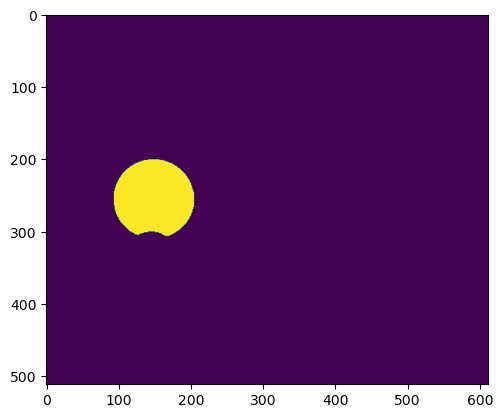

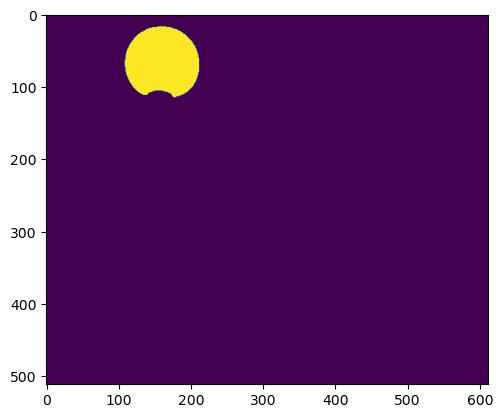

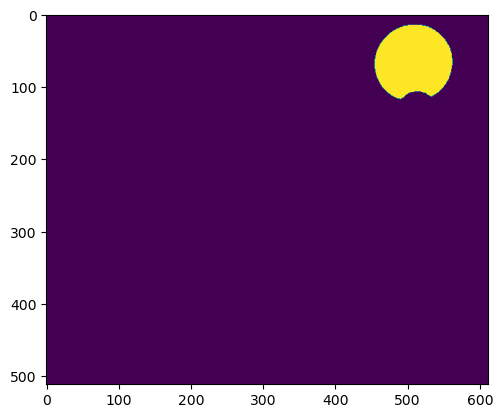

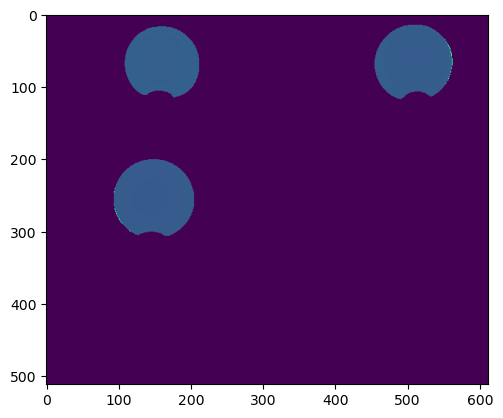

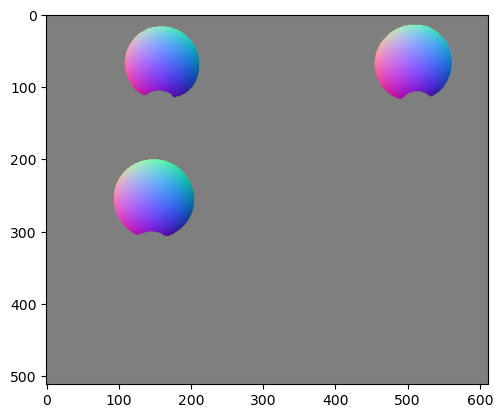

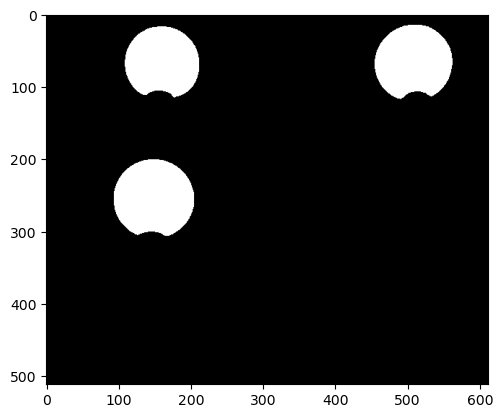

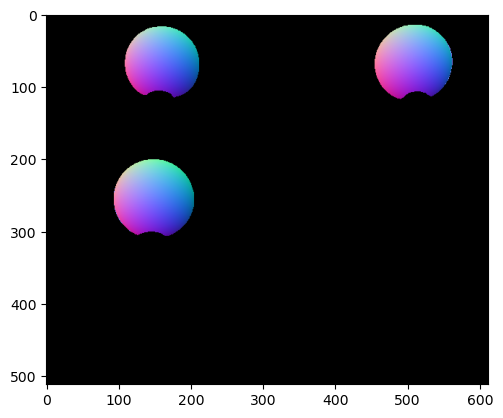

In [40]:

mask_path = ['/bean/DDIR_capture/20241127_multiple_sphere/00.png',
'/bean/DDIR_capture/20241127_multiple_sphere/01.png',
# '/bean/DDIR_capture/20241127_multiple_sphere/02.png'
'/bean/DDIR_capture/20241127_multiple_sphere/03.png'
]

total_normal = np.zeros((512,612,3))
total_depth = np.zeros((512,612))
mask = np.zeros((512,612,3))

save_dir = '/bean/DDIR_capture/20241127_multiple_sphere/main'
weight_map = []
idx = [0,1,3]
for i in range(len(mask_path)):
    masked_img = cv2.imread(mask_path[i], cv2.IMREAD_UNCHANGED)
    # print(masked_img.shape)
    
    # print(masked_img[:,:,3].shape)
    temp = masked_img[:,:,3]>0.99
    # temp = np.repeat(masked_img[:,:,3][:, :, np.newaxis], 3, axis=-1)  # shape: (2, 2, 3)
    # print(temp.shape)
    weight_map.append(temp)
    mask = mask+temp[...,np.newaxis]
    normal = np.load(f'/bean/DDIR_capture/20241127_multiple_sphere/for_GT/{idx[i]}_geo_normal_img.npy')
    depth = np.load(f'/bean/DDIR_capture/20241127_multiple_sphere/for_GT/{idx[i]}_depth_raw.npy')
    total_normal[temp] = normal[temp]
    total_depth[temp] = depth[temp]
    
    # pad = np.ones((9394,1))
    
    # temp2 = masked_img[temp][:3] = np.concatenate(normal[temp], pad)
    # plt.imshow(temp2)
    # plt.show()
    # plt.imshow(temp-masked_img[:,:,3])
    plt.imshow(temp)
    # plt.imshow(masked_img[:,:,3]-temp)
    plt.show()
plt.imshow(total_depth)
plt.show()
plt.imshow((-total_normal+1)/2)
plt.show()
plt.imshow(mask)
plt.show()
plt.imshow(((-total_normal+1)/2)*mask)
plt.show()


coeff = np.array(weight_map)
np.save(os.path.join(save_dir, f'coeff.npy'), coeff)
np.save(os.path.join(save_dir, f'depth.npy'), total_depth)
np.save(os.path.join(save_dir, f'normal.npy'), total_normal)
np.save(os.path.join(save_dir, f'mask.npy'), mask)

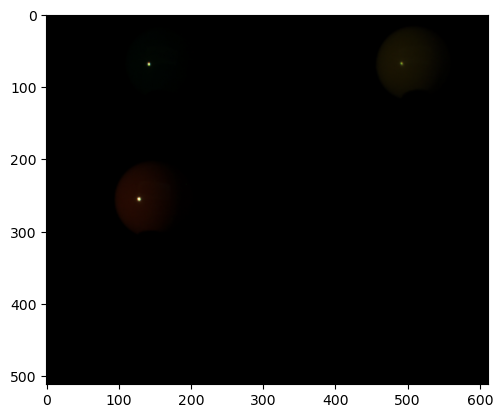

In [42]:
mask_path = ['/bean/DDIR_capture/20241127_multiple_sphere/00.png',
'/bean/DDIR_capture/20241127_multiple_sphere/01.png',
# '/bean/DDIR_capture/20241127_multiple_sphere/02.png',
'/bean/DDIR_capture/20241127_multiple_sphere/03.png'
]

indiv_path = ['20241127_multiple_sphere_00',
              '20241127_multiple_sphere_01',
            #   '20241127_multiple_sphere_02',
              '20241127_multiple_sphere_03'
              ]

total_normal = np.zeros((512,612,3))
total_depth = np.zeros((512,612))
mask = np.zeros((512,612,3))

save_dir = '/bean/DDIR_capture/20241127_multiple_sphere/main'


basis_main_dir = os.path.join('/bean/DDIR_capture/', '20241127_multiple_sphere', 'side/diffuseNspecular')
basis_side_dir = os.path.join('/bean/DDIR_capture/', '20241127_multiple_sphere', 'main/diffuseNspecular')

basis_file_names = [str(f).zfill(3)+'.png' for f in range(144)]

# basis_main = np.zeros((R*C, H, W, 3), dtype=np.float32)

for idx, fn in enumerate(basis_file_names):
    total_img = np.zeros((512,612,3))

    for i in range(len(mask_path)):
        basis_main_dir = os.path.join('/bean/DDIR_capture', indiv_path[i], 'side/800.0ms/diffuseNspecular')
        # basis_main_dir = os.path.join('/bean/DDIR_capture', indiv_path[i], 'side/diffuseNspecular')
        # basis_side_dir = os.path.join('/bean/DDIR_capture/', indiv_path[i], 'main/diffuseNspecular')
        
        # temp_img = np.load(os.path.join(basis_main_dir, fn))[:,:,::-1]
        temp_img = cv2.imread(os.path.join(basis_main_dir, fn))[:,:,::-1]/255.
        
        masked_img = cv2.imread(mask_path[i], cv2.IMREAD_UNCHANGED)
        # print(masked_img.shape)
        
        # print(masked_img[:,:,3].shape)
        temp = masked_img[:,:,3]>0.99
        total_img[temp] = temp_img[temp]
        
    np.save(os.path.join(save_dir, fn), total_img)
    cv2.imwrite(os.path.join(save_dir, fn), (np.clip(total_img[:,:,::-1],0,1)*255).astype(np.uint8))
plt.imshow(np.clip(total_img,0,1))
plt.show()
    

pos2d[541.5, 245.5] 53.6
pos2d[542.5, 246.5] 56.5


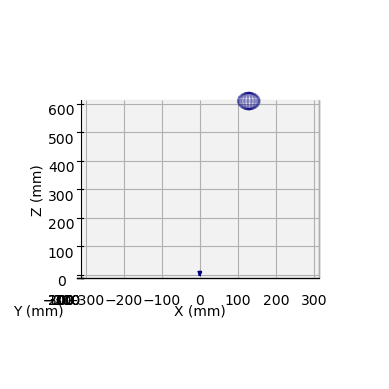

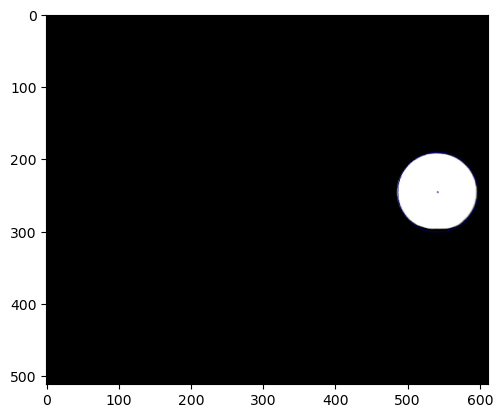

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


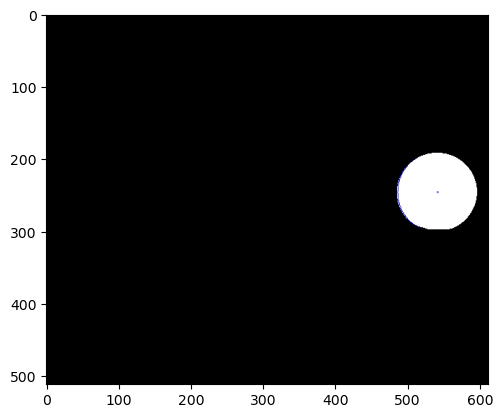

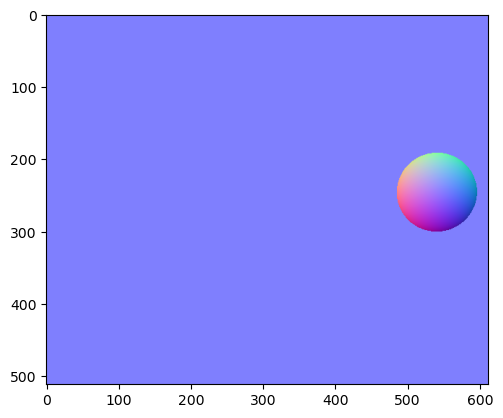

In [10]:
# %matplotlib widget
camera_parameter_path = '/root/workspace/DDIR/calibration'
# in_m_root = 'C:/Users/owner/Documents/hpBRDF/stereo_calib/matrix_pair/origin_{}'.format(cam_idx_pair)
# ex_m_root = 'C:/Users/owner/Documents/hpBRDF/stereo_calib/matrix_pair/origin_{}'.format(cam_idx_pair)
sphere_image_root = [
                    #  '/bean/DDPS_captures/240418/240418_big_1600_00',
                    #  '/bean/DDPS_captures/240418/240418_glossy_1600_00',
                    #  '/bean/DDPS_captures/240418/240418_plastic_1600_00',
                    #  '/bean/DDPS_captures/240418/240418_rubber_1600_00'
                     
                    #  '/bean/DDIR_capture/20240911_sphere00',
                    #  '/bean/DDIR_capture/20240925_sphere01',
                    #  '/bean/DDIR_capture/20240925_sphere02'
                     
                     
                    #  '/bean/DDIR_capture/20241127_multiple_sphere_00',
                    #  '/bean/DDIR_capture/20241127_multiple_sphere_01',
                    #  '/bean/DDIR_capture/20241127_multiple_sphere_02',
                    #  '/bean/DDIR_capture/20241127_multiple_sphere_03'
                     
                    #  '/bean/DDIR_capture/20241127_multiple_sphere/for_GT/00.png',
                    #  '/bean/DDIR_capture/20241127_multiple_sphere/for_GT/01.png',
                     '/bean/DDIR_capture/20241127_multiple_sphere/for_GT/02.png',
                    #  '/bean/DDIR_capture/20241127_multiple_sphere/for_GT/03.png'


                    #  '/bean/DDPS_captures/240417_sphere/240328_sphere00',
                    #  '/bean/DDPS_captures/240417_sphere/240328_sphere01',
                    #  '/bean/DDPS_captures/240417_sphere/240328_sphere02',
                    #  '/bean/DDPS_captures/240417_sphere/240328_sphere03',
                    #  '/bean/DDPS_captures/240417_sphere/240417_glossy_0',
                    #  '/bean/DDPS_captures/240417_sphere/240417_glossy_1',
                    #  '/bean/DDPS_captures/240417_sphere/240417_mat_0',
                    #  '/bean/DDPS_captures/240417_sphere/240417_mat_1'
                    ]

sphere_radius = [
                #  150/2,
                #  70/2,
                #  58/2,
                #  62/2
                
                # 130/2,
                # 62/2,
                # 58/2
                
                58/2,
                # 58/2,
                # 58/2,
                # 58/2
                 
                # 150 / 2,
                #  150 / 2,
                #  150 / 2,
                #  150 / 2,
                #  62 / 2,
                #  58 / 2,
                #  70 / 2,
                #  70 / 2
                 ]

colors = plt.cm.jet(np.linspace(0, 1, 51))
image_size = pos2d(612, 512)
# sphere_radius = 150 / 2

opt = Options().parse()
angle_stage_sphere, gain_sphere, exposure_sphere = 0, 1.0, 500


# pos_stepper_list = [0, 50]
# cam_idx_list = [50]
# angle_stage_list = [80, 120, 160]

ax = set_3d_plot()
in_m, ex_m = load_matrix(0, camera_parameter_path, camera_parameter_path)
ex_m = np.array([[1, 0, 0, 0],
                 [0, 1, 0, 0],
                 [0, 0, 1, 0],
                 [0, 0, 0, 1]])
[[f_x, _, c_x], [_, _, c_y], [_, _, _]] = in_m


color = colors[0]
# handle with camera
pos_cam, lookat_cam = calc_camera_pos(ex_m)
draw_camera_frustum(ax, in_m, ex_m, image_size, color)
for i in range(len(sphere_image_root)):
    # sphere_image_path = os.path.join(sphere_image_root[i], 'main/diffuse/wallpaper.png')
    # sphere_image_path = os.path.join(sphere_image_root[i], 'mask.png')
    # handle with sphere
    image_sphere = cv2.imread(sphere_image_root[i], cv2.IMREAD_UNCHANGED)[:,:,3]
    # image_sphere = cv2.imread(sphere_image_path)
    # image_sphere = image_sphere[:,:,::-1]
    
    image_sphere = np.repeat(image_sphere[:, :, np.newaxis], 3, axis=-1)
    circle_center, circle_radius = get_circle(image_sphere)
    print(circle_center, circle_radius)
    circle_center.x = 542.5
    circle_center.y = 246.5
    circle_radius = 56.5
    print(circle_center, circle_radius)
    circle_save_path = './'
    os.makedirs(circle_save_path, exist_ok=True)
    write_circle(image_sphere, circle_center, circle_radius, color, os.path.join(circle_save_path, 'circle_0.png'))
    pos_sphere_center = calc_sphere_center(in_m, ex_m, image_size, circle_center, radius_image=circle_radius, radius=sphere_radius[i])

    draw_sphere(ax, pos_sphere_center, sphere_radius[i], color)
    plt.show()
    plt.imshow(image_sphere)
    plt.show()

    sphere = {}
    sphere['center'] = (pos_sphere_center.np()*1e-3).reshape(1,3)
    sphere['radius'] = np.array([[sphere_radius[i]*1e-3]])
    sphere['num of sphere'] = 1


    # initialize assets
    ptcloud = np.zeros((opt.R, opt.C, 3))
    normal = np.zeros((opt.R, opt.C, 3))
    mask = np.zeros((opt.R, opt.C))

    # fill assets with background
    H_bg_min = (-c_y) * opt.camera_pitch * opt.background_distance / opt.lens_focal_length_y
    W_bg_min = (-c_x) * opt.camera_pitch * opt.background_distance / opt.lens_focal_length_x

    H_bg_max = (opt.camera_row-c_y) * opt.camera_pitch * opt.background_distance / opt.lens_focal_length_y
    W_bg_max = (opt.camera_col-c_x) * opt.camera_pitch * opt.background_distance / opt.lens_focal_length_x
    
    H_ = np.linspace(H_bg_min, H_bg_max, opt.R)
    W_ = np.linspace(W_bg_min, W_bg_max, opt.C)

    # H_bg = opt.camera_row * opt.camera_pitch * opt.background_distance / opt.lens_focal_length_y
    # W_bg = opt.camera_col * opt.camera_pitch * opt.background_distance / opt.lens_focal_length_x
    # H_ = np.linspace(-H_bg/2, H_bg/2, opt.R)
    # W_ = np.linspace(-W_bg/2, W_bg/2, opt.C)
    y, x = np.meshgrid(H_, W_, indexing='ij')
    ptcloud[:,:,0] = x
    ptcloud[:,:,1] = y
    ptcloud[:,:,2] = opt.background_distance

    normal[:,:] = [0, 0, -1]

    # for each pixel, shoot a ray
    for r in range(opt.R):
        for c in range(opt.C):
            sphere_num, coordinate, normal_vec = collision_check(ptcloud, sphere, r, c)
            if (sphere_num):
                ptcloud[r][c] = coordinate
                mask[r][c] = sphere_num
                normal[r][c] = normal_vec

    normal = normal / (np.expand_dims(np.linalg.norm(normal, axis=-1), axis=-1)+1e-8)
    depth = ptcloud[:,:,2]
    plt.imshow(image_sphere*mask[...,None])
    plt.show()
    plt.imshow((-normal+1)/2)
    plt.show()
    
    save_dir = '/bean/DDIR_capture/20241127_multiple_sphere/for_GT/'
    
    np.save(os.path.join(save_dir, f'2_geo_normal_img.npy'), normal)
    np.save(os.path.join(save_dir, f'2_depth_raw.npy'), depth)
    np.save(os.path.join(save_dir, f'2_geo_normal_img_mask.npy'), mask)

array([[0.45664637, 0.45620857, 0.4557897 , ..., 0.44747987, 0.44745057,
        0.44742679],
       [0.45650023, 0.45606671, 0.45565175, ..., 0.44739339, 0.44736417,
        0.44734044],
       [0.45636419, 0.45593461, 0.45552325, ..., 0.44731283, 0.44728368,
        0.44726001],
       ...,
       [0.4590741 , 0.45859459, 0.45813783, ..., 0.44935248, 0.44932306,
        0.44929943],
       [0.45935679, 0.45886915, 0.45840508, ..., 0.4495313 , 0.44950178,
        0.4494781 ],
       [0.45965414, 0.45915764, 0.45868561, ..., 0.44971715, 0.44968753,
        0.44966379]])

255


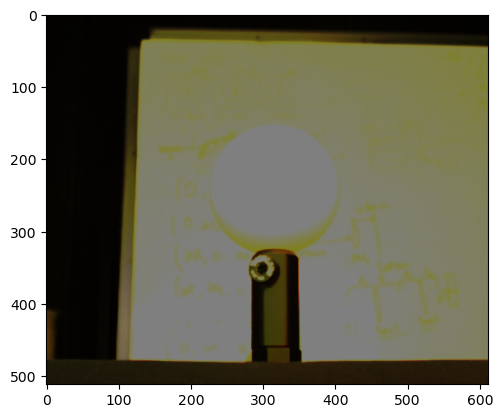

In [ ]:
plt.imshow(image_sphere/255/2)
print(image_sphere.max())

In [ ]:
[[f_x, _, c_x], [_, _, c_y], [_, _, _]] = in_m

H_bg_min = (-c_y) * opt.camera_pitch * opt.background_distance / opt.lens_focal_length_y
W_bg_min = (-c_x) * opt.camera_pitch * opt.background_distance / opt.lens_focal_length_x

H_bg_max = (opt.camera_row-c_y) * opt.camera_pitch * opt.background_distance / opt.lens_focal_length_y
W_bg_max = (opt.camera_col-c_x) * opt.camera_pitch * opt.background_distance / opt.lens_focal_length_x
print(H_bg_min, H_bg_max)


H_ = np.linspace(H_bg_min, H_bg_max, opt.R)
W_ = np.linspace(W_bg_min, W_bg_max, opt.C)

# H_bg = opt.camera_row * opt.camera_pitch * opt.background_distance / opt.lens_focal_length_y
# W_bg = opt.camera_col * opt.camera_pitch * opt.background_distance / opt.lens_focal_length_x
# print(H_bg)

-0.4933639576492763 0.399966881441335


In [ ]:
print(pos_sphere_center)
print(in_m)
circle_center.np()


pos3d[7.802819421931381, -51.79743985123381, 511.65808795803576]
[[1.1484685e+03 0.0000000e+00 2.9998578e+02]
 [0.0000000e+00 1.1515525e+03 2.8276461e+02]
 [0.0000000e+00 0.0000000e+00 1.0000000e+00]]


array([317.5, 166.5], dtype=float32)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


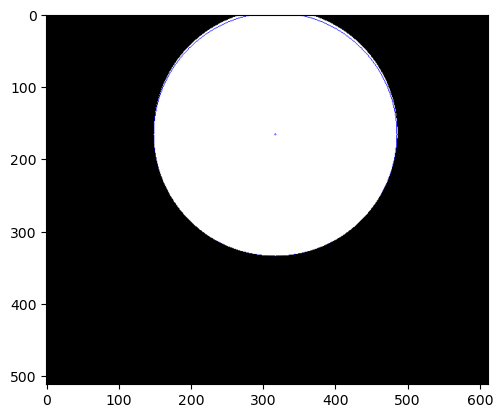

In [ ]:
plt.imshow(image_sphere*mask[...,None])
temp = image_sphere
temp[253, 317, 0] = 255
# plt.imshow(temp)

[75.0]

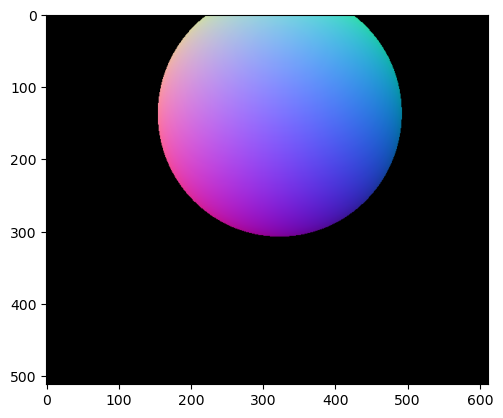

In [ ]:
plt.imshow(((-normal+1)/2)*mask[...,None])
sphere_radius

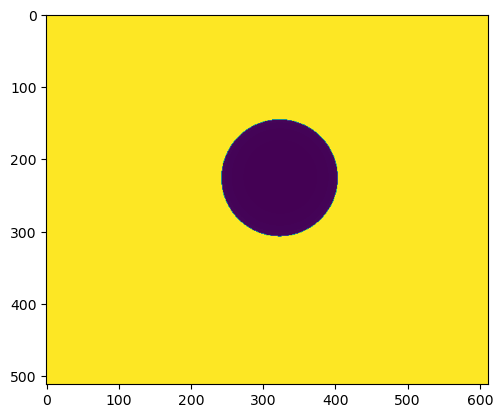

In [ ]:
plt.imshow(depth)

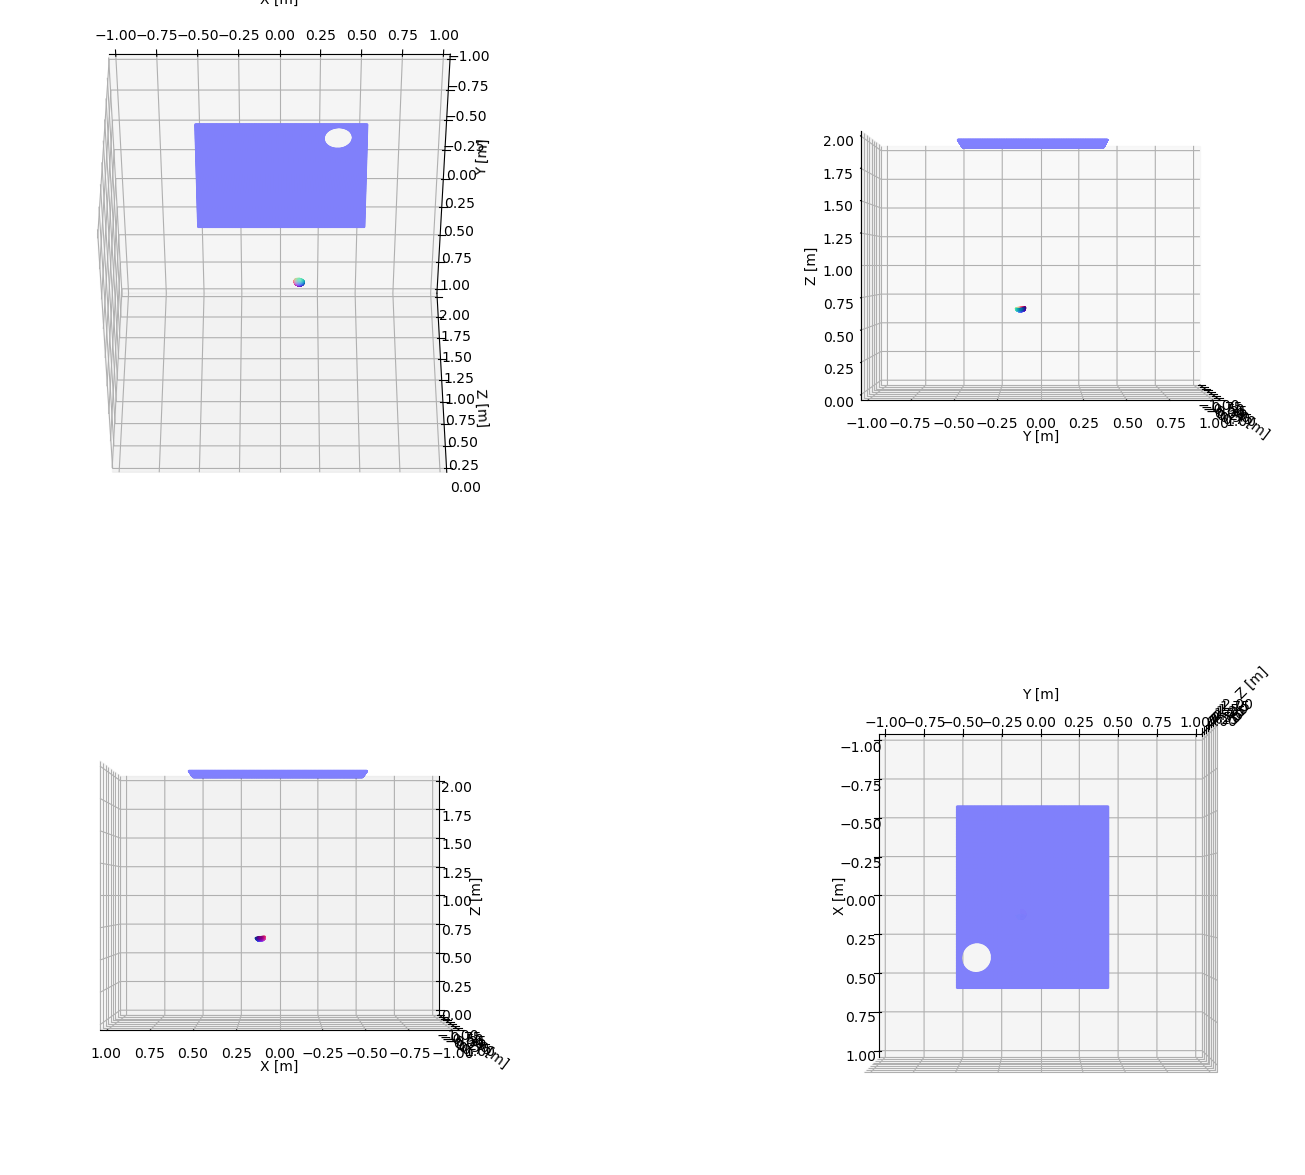

In [29]:
# %matplotlib widget
# plt.imshow((-normal+1)/2)
# plt.imshow(ptcloud[:,:,2])
# print(sphere)
visualize3D((-normal+1)/2, ptcloud)
plt.show()

/bean/DDPS_captures/240418/240418_black_1600/main/diffuse/000.png


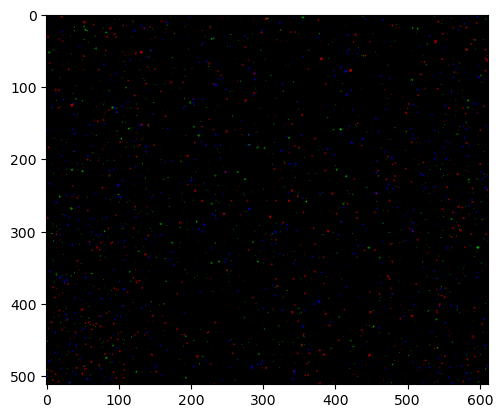

In [ ]:
black_img_root = [
                    # '/bean/DDPS_captures/240417_black/240417_black_20',
                    #  '/bean/DDPS_captures/240417_black/240417_black_100',
                    #  '/bean/DDPS_captures/240417_black/240417_black_200',
                    #  '/bean/DDPS_captures/240417_black/240417_black_400',
                    #  '/bean/DDPS_captures/240417_black/240417_black_500',
                    #  '/bean/DDPS_captures/240417_black/240417_black_700',
                    #  '/bean/DDPS_captures/240417_black/240417_black_1000',
                    #  '/bean/DDPS_captures/240417_black/240417_black_1300',
                    #  '/bean/DDPS_captures/240417_black/240417_black_1600',
                    #  '/bean/DDPS_captures/240417_black/240417_black_1900'
                     '/bean/DDPS_captures/240418/240418_black_1600'
                     ]
for i in range(len(black_img_root)):
    black_img_path = os.path.join(black_img_root[i], 'main/diffuse/000.png')
    black_img = cv2.imread(black_img_path)[:,:,::-1]
    print(black_img_path)
    plt.imshow(black_img*144)
    plt.show()

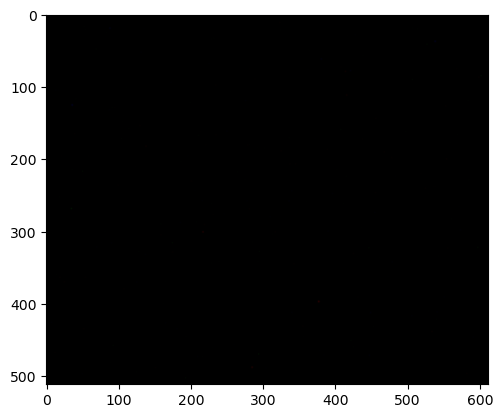

In [ ]:
black_img = cv2.imread(black_img_path)
plt.imshow(black_img)